<a href="https://colab.research.google.com/github/alinepsantos/TCC-PUC/blob/main/Predi%C3%A7%C3%A3o_Censo_Agropecu%C3%A1rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODELOS DE PREDIÇÃO APLICADOS AO CENSO AGROPECUÁRIO – UMA ANÁLISE SOBRE A DESPESA COM SALÁRIOS NO CAMPO

PUC Minas

Pós Graduação em Ciência de Dados e Big Data

Trabalho de conclusão de curso

Aluna: Aline Pamela Santos

O presente trabalho visa à análise da relação entre a renda e o trabalho na agricultura brasileira. Para isso, houve a aplicação dos algoritmos de aprendizado de máquina na base de dados do Censo Agropecuário com a finalidade de predição das despesas com salários oriundos das áreas agrícolas produtivas do território brasileiro.

# Importar Bibliotecas

In [1]:
import pandas as pd
import requests as r
import csv
import statistics as sts
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statistics import mean
from pandas.core.groupby.generic import generate_property
generate_property
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from google.colab import drive
from matplotlib import rcParams
from google.colab import output
from google.colab import data_table
from sklearn.metrics import r2_score

In [3]:
# Aumenta o tamanho dos gráficos
rcParams['figure.figsize'] = 12.7,9.27
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
#Numero de linhas do Pandas ao exibir dados
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
#Necessário para a exibição do heatmap
output.enable_custom_widget_manager()
#Setando paletta de cores do SNS
sns.set_palette("Paired")
data_table.enable_dataframe_formatter()
np.random.seed(777)

# Coleta de Dados

Inicialmente foi necessário importar para o notebook do Google Colab os datasets no formato to “csv” que se encontram hospedados no repositório do github (https://github.com/alinepsantos/TCC-PUC), para facilitar o acesso:

In [4]:
atlas_df=pd.read_csv('https://raw.githubusercontent.com/alinepsantos/TCC-PUC/main/Atlas.csv')
censo_df=pd.read_csv('https://raw.githubusercontent.com/alinepsantos/TCC-PUC/main/municipio.csv')
ibge_df=pd.read_csv('https://github.com/alinepsantos/TCC-PUC/raw/main/RELATORIO_DTB_BRASIL_MUNICIPIO.csv', encoding='cp1252', sep=";")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3,5,7,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
censo_df=censo_df[['ano','sigla_uf','id_municipio','area_total','area_lavoura_permanente','area_lavoura_temporaria','area_pastagem','area_sistema_agroflorestal','area_mata','area_nao_utilizada','valor_producao_total_animal','valor_total_producao_lavoura_temporaria','valor_total_producao_lavoura_permanente','valor_total_producao_cafe','valor_total_arroz','valor_total_feijao','valor_total_milho','valor_total_mandioca','valor_total_soja','valor_total_algodao','valor_total_cana','valor_total_trigo','valor_producao_total','despesa_salarios']]
censo_df.head()

,ano,sigla_uf,id_municipio,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios
0,1985,RO,1100023,NaN,NaN,NaN,NaN,696660.25,NaN,64,NaN,NaN,14160.41,71654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,RO,1100049,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,23583.55,86291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,RO,1100056,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,5790.77,14486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,RO,1100064,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,18242.31,34057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,RO,1100080,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,19194.16,31114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
atlas_df=atlas_df[['ano','id_municipio','idhm','idhm_e','idhm_l','idhm_r']]
atlas_df.head()

,ano,id_municipio,idhm,idhm_e,idhm_l,idhm_r
0,1991,1100015,0.329,0.112,0.617,0.516
1,1991,1100023,0.432,0.199,0.684,0.593
2,1991,1100031,0.309,0.108,0.636,0.430
3,1991,1100049,0.407,0.171,0.667,0.593
4,1991,1100056,0.386,0.167,0.629,0.547


In [7]:
ibge_df

,UF,Nome_UF,Região Geográfica Intermediária,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,11.0,Rondônia,1102.0,Ji-Paraná,110005.0,Cacoal,2.0,Leste Rondoniense,6.0,Cacoal,15.0,1100015.0,Alta Floresta D'Oeste,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,Rondônia,1102.0,Ji-Paraná,110005.0,Cacoal,2.0,Leste Rondoniense,6.0,Cacoal,379.0,1100379.0,Alto Alegre dos Parecis,NaN,NaN,NaN,NaN,NaN,NaN
2,11.0,Rondônia,1101.0,Porto Velho,110002.0,Ariquemes,2.0,Leste Rondoniense,3.0,Ariquemes,403.0,1100403.0,Alto Paraíso,NaN,NaN,NaN,NaN,NaN,NaN
3,11.0,Rondônia,1102.0,Ji-Paraná,110004.0,Ji-Paraná,2.0,Leste Rondoniense,5.0,Alvorada D'Oeste,346.0,1100346.0,Alvorada D'Oeste,NaN,NaN,NaN,NaN,NaN,NaN
4,11.0,Rondônia,1101.0,Porto Velho,110002.0,Ariquemes,2.0,Leste Rondoniense,3.0,Ariquemes,23.0,1100023.0,Ariquemes,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ibge_df=ibge_df[['Código Município Completo','Nome_Município']]
ibge_df.head()

,Código Município Completo,Nome_Município
0,1100015.0,Alta Floresta D'Oeste
1,1100379.0,Alto Alegre dos Parecis
2,1100403.0,Alto Paraíso
3,1100346.0,Alvorada D'Oeste
4,1100023.0,Ariquemes


In [9]:
ibge_rename=ibge_df.rename(columns={'Código Município Completo':'id_municipio'})

As células abaixo foram escritas para a verificação da quantidade de linhas e do tipo de variável de cada dataset:

In [10]:
rows_atlas=atlas_df.shape[0]
rows_censo=censo_df.shape[0]
rows_ibge=ibge_df.shape[0]
print('Quantidade de linhas atlas_df:',rows_atlas)
print('Quantidade de linhas censo_df:',rows_censo)
print('Quantidade de linhas ibge_df:',rows_ibge)

Quantidade de linhas atlas_df: 16695
Quantidade de linhas censo_df: 20738
Quantidade de linhas ibge_df: 1048575


In [11]:
print(type(atlas_df))
print(type(censo_df))
print(type(ibge_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Tratamento de Dados

Nas linhas abaixo foi feito o procedimento de união das tabelas (*merge*), e em sequência a concatenação para que todos os dados estejam em único *dataset*:

In [12]:
censo_df_1985=censo_df.loc[censo_df['ano']==1985]
censo_df_1995=censo_df.loc[censo_df['ano']==1996]
censo_df_2006=censo_df.loc[censo_df['ano']==2006]
censo_df_2017=censo_df.loc[censo_df['ano']==2017]
atlas_df_1991=atlas_df.loc[atlas_df['ano']==1991]
atlas_df_2000=atlas_df.loc[atlas_df['ano']==2000]
atlas_df_2010=atlas_df.loc[atlas_df['ano']==2010]
censo1985_atlas1991=censo_df_1985.merge(atlas_df_1991,on='id_municipio')
censo1995_atlas1991=censo_df_1995.merge(atlas_df_1991,on='id_municipio')
censo2006_atlas2000=censo_df_2006.merge(atlas_df_2000,on='id_municipio')
censo2017_atlas2010=censo_df_2017.merge(atlas_df_2010,on='id_municipio')

In [13]:
dados_concat=pd.concat([censo1985_atlas1991,censo1995_atlas1991,censo2006_atlas2000,censo2017_atlas2010], axis=0, ignore_index=True)
dados_concat.head()

,ano_x,sigla_uf,id_municipio,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios,ano_y,idhm,idhm_e,idhm_l,idhm_r
0,1985,RO,1100023,NaN,NaN,NaN,NaN,696660.25,NaN,64,NaN,NaN,14160.41,71654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.432,0.199,0.684,0.593
1,1985,RO,1100049,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,23583.55,86291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.407,0.171,0.667,0.593
2,1985,RO,1100056,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,5790.77,14486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.386,0.167,0.629,0.547
3,1985,RO,1100064,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,18242.31,34057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.376,0.151,0.658,0.536
4,1985,RO,1100080,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,19194.16,31114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.425,0.220,0.629,0.553


In [14]:
dados_merge_ibge=dados_concat.merge(ibge_rename,on='id_municipio')
dados_merge_ibge.tail()

,ano_x,sigla_uf,id_municipio,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios,ano_y,idhm,idhm_e,idhm_l,idhm_r,Nome_Município
20728,2006,GO,5210158,18541.4,102.69,4829.01,11730.40,1556.77,286.82,27,NaN,0.0,1208.42,19989,NaN,0.0,0.0,0.00,0.0,187138.5,157632.9,NaN,NaN,1255.51,2000,0.559,0.392,0.761,0.586,Ipiranga de Goiás
20729,2017,GO,5210158,16749.0,153.00,5706.00,8837.00,98.00,1586.00,306,7.0,21.0,360.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,428.00,2010,0.696,0.642,0.816,0.643,Ipiranga de Goiás
20730,2006,GO,5212253,53791.7,30.37,2548.13,43441.91,7378.77,105.11,13,NaN,0.0,16.30,50702,NaN,0.0,0.0,5046.38,0.0,414983.3,289729.4,NaN,NaN,NaN,2000,0.559,0.366,0.815,0.585,Lagoa Santa
20731,2017,GO,5212253,43446.0,68.00,66.00,33933.00,0.00,8439.00,427,0.0,0.0,30.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,113.00,2010,0.740,0.638,0.868,0.733,Lagoa Santa
20732,2017,PI,2206720,10547.0,1190.00,1216.00,3374.00,1104.00,2003.00,1586,95.0,126.0,207.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,870.00,2010,0.602,0.512,0.780,0.546,Nazária


In [15]:
dados_rename=dados_merge_ibge.rename(columns={'ano_x':'ano_censo_agropecuario','id_municipio':'codigo_ibge','sigla_uf':'uf','Nome_Município':'municipio','ano_y':'ano_atlas'})
dados_rename.head()

,ano_censo_agropecuario,uf,codigo_ibge,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios,ano_atlas,idhm,idhm_e,idhm_l,idhm_r,municipio
0,1985,RO,1100023,NaN,NaN,NaN,NaN,696660.25,NaN,64,NaN,NaN,14160.41,71654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.432,0.199,0.684,0.593,Ariquemes
1,1996,RO,1100023,NaN,NaN,NaN,NaN,NaN,NaN,12,0.0,0.0,857.00,150832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1927.0,1991,0.432,0.199,0.684,0.593,Ariquemes
2,2006,RO,1100023,359879.88,NaN,NaN,NaN,134616.75,NaN,111,NaN,NaN,NaN,344500,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2000,0.556,0.343,0.742,0.674,Ariquemes
3,2017,RO,1100023,334256.00,5235.0,5341.0,221786.0,1573.00,89480.0,10692,19.0,18.0,1282.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.0,2928.0,2010,0.702,0.600,0.806,0.716,Ariquemes
4,1985,RO,1100049,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,23583.55,86291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991,0.407,0.171,0.667,0.593,Cacoal


# Tratamento de Valores Nulos

Podemos observar que em alguns campos o número dos registros inválidos ultrapas-sa a metade dos números de registros totais da nossa base de dados, o que torna inviável a exclusão de tais linhas. 
 


In [16]:
dados_rename.isnull().sum()

ano_censo_agropecuario                         0
uf                                             0
codigo_ibge                                    0
area_total                                  5480
area_lavoura_permanente                     9884
area_lavoura_temporaria                    10653
area_pastagem                              10223
area_sistema_agroflorestal                 10353
area_mata                                  10764
area_nao_utilizada                             0
valor_producao_total_animal                 8603
valor_total_producao_lavoura_temporaria     7007
valor_total_producao_lavoura_permanente     1890
valor_total_producao_cafe                      0
valor_total_arroz                          19159
valor_total_feijao                         15451
valor_total_milho                          15294
valor_total_mandioca                       18114
valor_total_soja                           15637
valor_total_algodao                        18414
valor_total_cana    

O preenchimento dos valores nulos dos campos relacionados aos valores totais, tais como as colunas correspondentes a área total, ao valor de produção total e a despesa com os salários, pelas médias de seus respectivos munícipios.

In [17]:
lista_municipio =  list(dados_rename['municipio'].drop_duplicates())
lista_colunas = ['area_total',
'valor_producao_total',
'despesa_salarios']

def get_medias_by_municipio(municipio, coluna):
  return dados_rename.loc[(dados_rename['municipio'] == municipio), [coluna]].mean()

for coluna in lista_colunas:
  for municipio in lista_municipio:
    media = get_medias_by_municipio(municipio, coluna)
    dados_rename.loc[(dados_rename['municipio'] == municipio), [coluna]] = dados_rename.loc[(dados_rename['municipio'] == municipio), [coluna]].fillna(media)

Os registros nulos restantes  foram substituídos  por zero, pois é absolutamente possível que uma área não tenha  todos os tipos de culturas. 

In [18]:
dados_rename=dados_rename.fillna(0)

In [19]:
dados_rename.isnull().sum()

ano_censo_agropecuario                     0
uf                                         0
codigo_ibge                                0
area_total                                 0
area_lavoura_permanente                    0
area_lavoura_temporaria                    0
area_pastagem                              0
area_sistema_agroflorestal                 0
area_mata                                  0
area_nao_utilizada                         0
valor_producao_total_animal                0
valor_total_producao_lavoura_temporaria    0
valor_total_producao_lavoura_permanente    0
valor_total_producao_cafe                  0
valor_total_arroz                          0
valor_total_feijao                         0
valor_total_milho                          0
valor_total_mandioca                       0
valor_total_soja                           0
valor_total_algodao                        0
valor_total_cana                           0
valor_total_trigo                          0
valor_prod

In [20]:
dados=dados_rename
dados.head()

,ano_censo_agropecuario,uf,codigo_ibge,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios,ano_atlas,idhm,idhm_e,idhm_l,idhm_r,municipio
0,1985,RO,1100023,347067.94,0.0,0.0,0.0,696660.25,0.0,64,0.0,0.0,14160.41,71654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,304.5,2427.5,1991,0.432,0.199,0.684,0.593,Ariquemes
1,1996,RO,1100023,347067.94,0.0,0.0,0.0,0.00,0.0,12,0.0,0.0,857.00,150832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1927.0,1991,0.432,0.199,0.684,0.593,Ariquemes
2,2006,RO,1100023,359879.88,0.0,0.0,0.0,134616.75,0.0,111,0.0,0.0,0.00,344500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,304.5,2427.5,2000,0.556,0.343,0.742,0.674,Ariquemes
3,2017,RO,1100023,334256.00,5235.0,5341.0,221786.0,1573.00,89480.0,10692,19.0,18.0,1282.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,594.0,2928.0,2010,0.702,0.600,0.806,0.716,Ariquemes
4,1985,RO,1100049,229728.14,0.0,0.0,0.0,0.00,0.0,23,0.0,0.0,23583.55,86291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,3690.5,1991,0.407,0.171,0.667,0.593,Cacoal


# Análise Exploratória

In [21]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [22]:
dados.describe()

,ano_censo_agropecuario,codigo_ibge,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total,despesa_salarios,ano_atlas,idhm,idhm_e,idhm_l,idhm_r
count,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000,20733.00000
mean,2002.13529,3248313.94540,64033.47319,586.61049,5918.94510,20032.08094,6493.38650,6100.76994,692.52573,1448.14261,586.06671,2579.55744,22745.59432,69.54785,1556.94273,230.85216,1150.88834,93.29334,62156.08780,44719.43825,63880.47512,25592.81577,1581.99919,1998.50871,0.49763,0.33129,0.70895,0.56756
std,11.46208,969560.39677,144251.40162,2226.95137,20496.85512,82045.88365,46271.28171,29091.98633,3164.71554,9531.80314,5698.72968,15140.36664,55172.69575,1206.30611,15272.96821,8554.79890,11816.16602,1386.64525,317592.04021,234756.83591,389920.91528,155462.88296,19351.70031,7.88257,0.14713,0.18515,0.09319,0.10492
min,1985.00000,1100015.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1991.00000,0.12000,0.01000,0.43300,0.22900
25%,1996.00000,2513968.00000,12317.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,0.00000,0.00000,2.00000,16.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,258.00000,1991.00000,0.38400,0.17500,0.64800,0.48800
50%,2006.00000,3145059.00000,25945.93000,0.00000,0.00000,0.00000,0.00000,0.00000,66.00000,0.00000,0.00000,107.00000,7382.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,98.00000,538.00000,2000.00000,0.49700,0.29500,0.71800,0.57300
75%,2017.00000,4115200.00000,59117.08000,272.27800,3161.00000,9978.00000,706.00000,1991.39000,371.00000,7.00000,15.00000,604.00000,21258.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2857.00000,1086.00000,2010.00000,0.61400,0.48700,0.77900,0.64900
max,2017.00000,5300108.00000,5267311.00000,57954.34000,579144.00000,3695165.00000,2195765.00000,1125574.00000,274144.00000,375923.00000,321049.25000,597135.70000,1727475.00000,75722.59000,858072.30000,802461.50000,617741.80000,72949.57000,8498327.00000,6374505.00000,9606732.00000,10326914.00000,1690891.50000,2010.00000,0.86200,0.81100,0.89400,0.89100


Observa-se a existência de muitos valores “outliers” no dataset. Porém, esse fenômeno pode estar relacionado com a alta concentração fundiária no país, onde há grandes proporções territoriais sob o domínio de poucos proprietários.

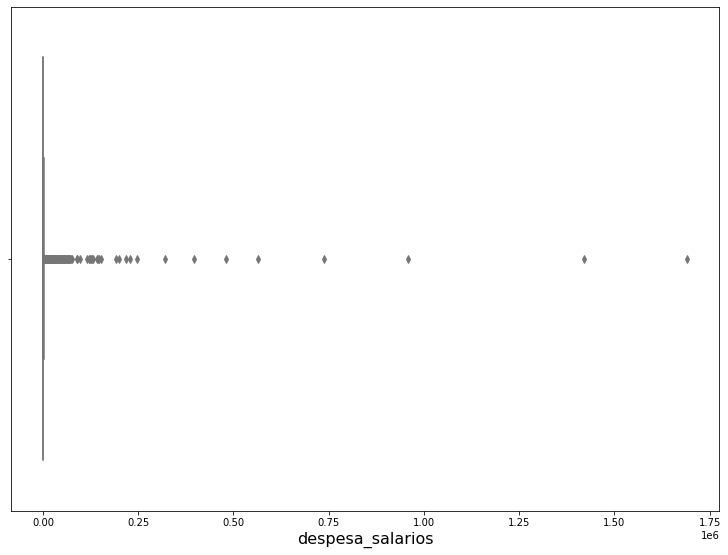

In [23]:
sns.boxplot(x=dados['despesa_salarios'])

A seguir, faremos o procedimento de remoção desses valores com intuito de melhorar o desempenho dos algoritmos de aprendizado de máquina que serão aplicados ao dataset. 

In [24]:
print(f"Deteccção de outliers:" 
      f"{dados.loc[dados['despesa_salarios'] >3000,['despesa_salarios']]}")

Deteccção de outliers:       despesa_salarios
4            3690.50000
5            3567.00000
6            3690.50000
7            3814.00000
28           3095.50000
...                 ...
20697        3475.00000
20702       70667.64000
20716       26115.41000
20718       48532.97000
20726       12554.94000

[1025 rows x 1 columns]


In [25]:
outliers=dados.loc[dados['despesa_salarios'] >3000,['despesa_salarios']]
outliers.shape

(1025, 1)

In [26]:
dados=dados.loc[dados['despesa_salarios'] <= 3000]

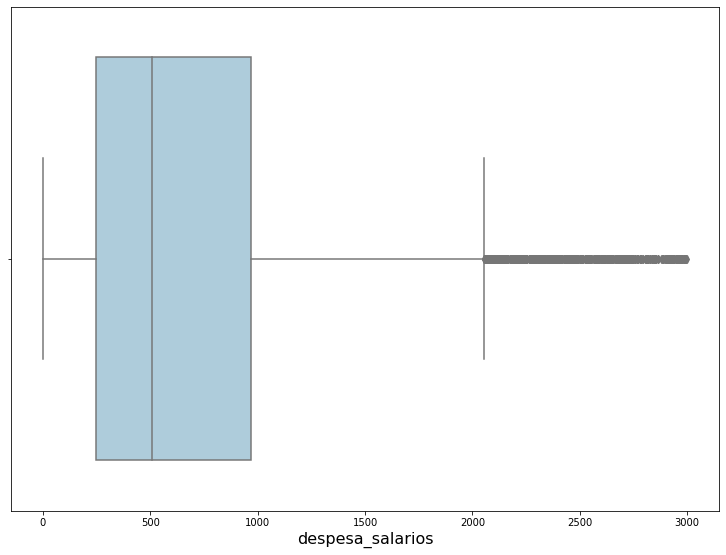

In [27]:
sns.boxplot(x=dados['despesa_salarios'])

A seguir apresentaremos alguns gráficos para um melhor entendimento dos dados da nossa base:

[Text(0, 0.5, 'Hectare (ha)'), Text(0.5, 0, 'Ano')]

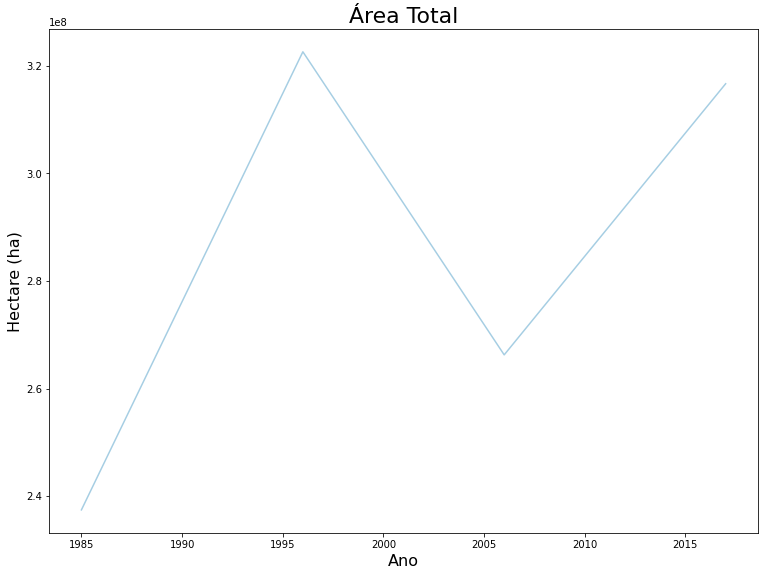

In [28]:
area_total_por_ano = dados.groupby('ano_censo_agropecuario')['area_total'].sum()
ax = area_total_por_ano.plot()
ax.set(title="Área Total")
ax.set(ylabel='Hectare (ha)',xlabel='Ano')

[Text(0, 0.5, 'Hectare (ha)'), Text(0.5, 0, 'Ano')]

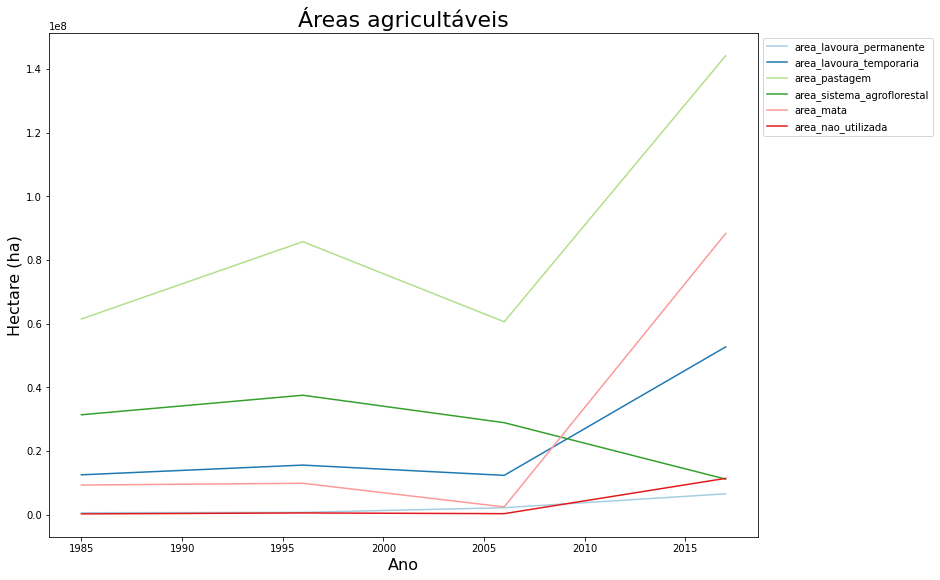

In [29]:
areas_por_ano = dados.groupby('ano_censo_agropecuario')[['area_lavoura_permanente','area_lavoura_temporaria','area_pastagem','area_sistema_agroflorestal','area_mata','area_nao_utilizada']].sum()
ax = areas_por_ano.plot()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title="Áreas agricultáveis")
ax.set(ylabel='Hectare (ha)',xlabel='Ano')

[Text(0, 0.5, 'Real (BRL)'), Text(0.5, 0, 'Ano')]

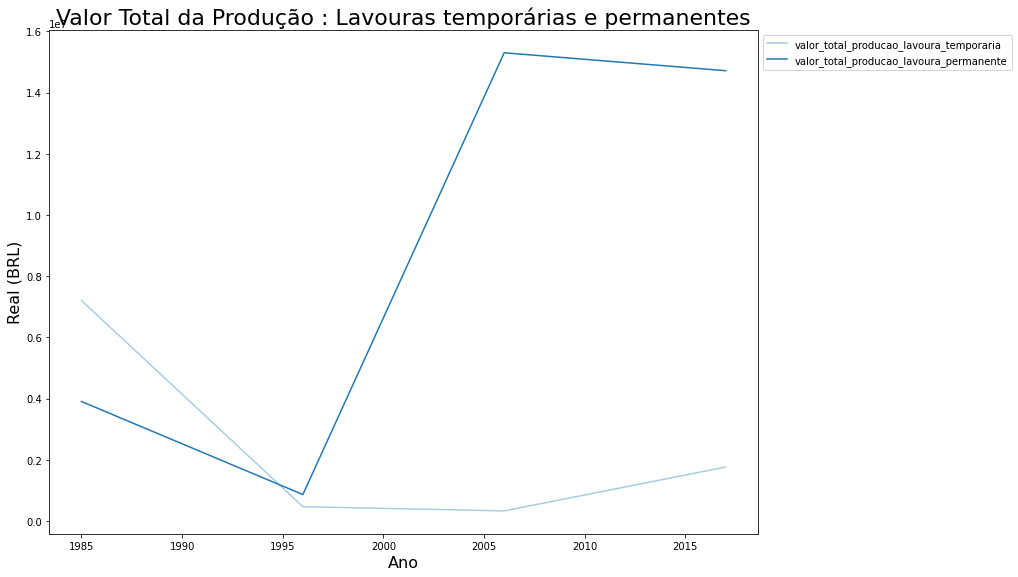

In [30]:
valor_por_ano = dados.groupby('ano_censo_agropecuario')[['valor_total_producao_lavoura_temporaria','valor_total_producao_lavoura_permanente']].sum()
ax = valor_por_ano.plot()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title="Valor Total da Produção : Lavouras temporárias e permanentes")
ax.set(ylabel='Real (BRL)',xlabel='Ano')

Por fim, vamos explorar a evolução do Índice de Desenvolvimento Humano Municipal para as cidades que detém as maiores áreas agropecuárias encontradas na nossa base de dados. 

In [31]:
dados_municipio=dados[['ano_censo_agropecuario','uf','municipio','area_total','idhm']]
dados_municipio=dados_municipio.groupby('ano_censo_agropecuario')
for municipio, data in dados_municipio:
    print(f"municipio: {municipio}\n\n{data.nlargest(5, ['area_total'])}", end='\n\n')

municipio: 1985

       ano_censo_agropecuario  uf        municipio    area_total    idhm
15275                    1985  MS          Corumbá 5267311.00000 0.50900
15495                    1985  MT          Cáceres 2504899.00000 0.42000
15591                    1985  MT      Paranatinga 2178431.00000 0.33400
15643                    1985  MT  Santa Terezinha 2009418.00000 0.32900
15387                    1985  MS   Porto Murtinho 1510567.00000 0.34700

municipio: 1996

       ano_censo_agropecuario  uf              municipio    area_total    idhm
15276                    1996  MS                Corumbá 5207767.00000 0.50900
15480                    1996  MT               Aripuanã 2415730.00000 0.41000
677                      1996  PA     São Félix do Xingu 2021925.38000 0.31500
20256                    1996  MT  Campo Novo do Parecis 1582000.00000 0.49500
15592                    1996  MT            Paranatinga 1571789.00000 0.33400

municipio: 2006

       ano_censo_agropecuario  uf  

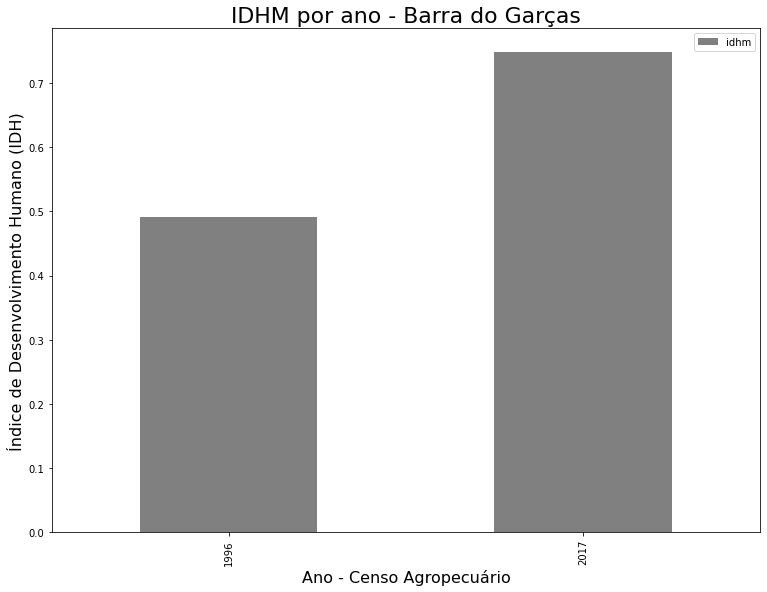

In [32]:
area_x_idh_bar_barra = dados.loc[dados['municipio'] == 'Barra do Garças', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_barra.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Barra do Garças', color='gray')

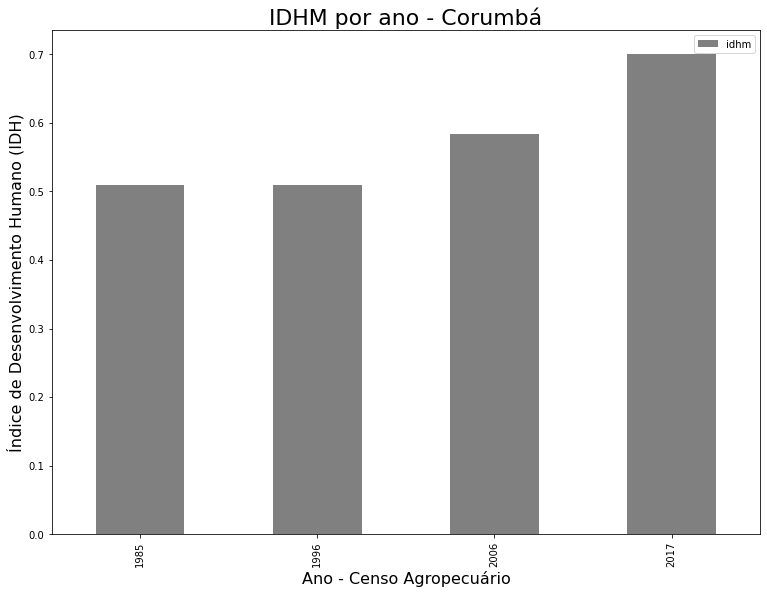

In [33]:
area_x_idh_bar_corumba = dados.loc[dados['municipio'] == 'Corumbá', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_corumba.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Corumbá', color='gray')

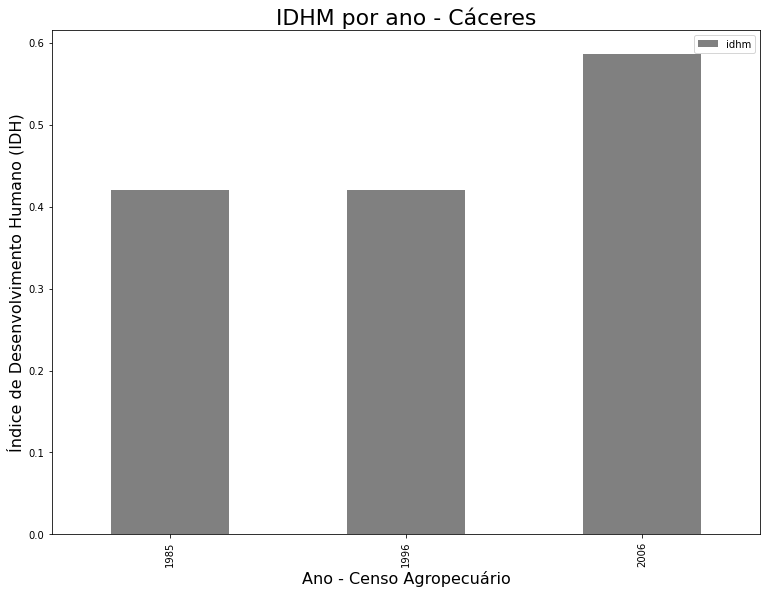

In [34]:
area_x_idh_bar_caceres = dados.loc[dados['municipio'] == 'Cáceres', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_caceres.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Cáceres', color='gray')

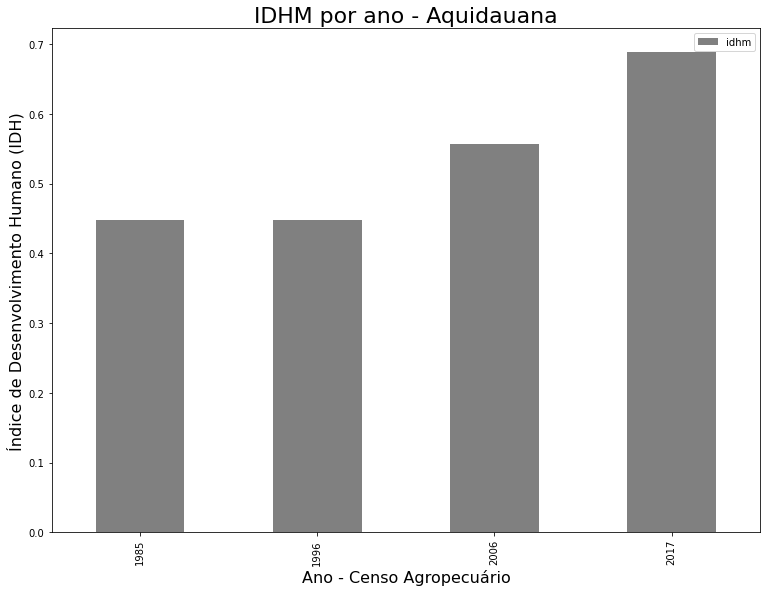

In [35]:
area_x_idh_bar_aquidauana = dados.loc[dados['municipio'] == 'Aquidauana', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_aquidauana.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Aquidauana', color='gray')

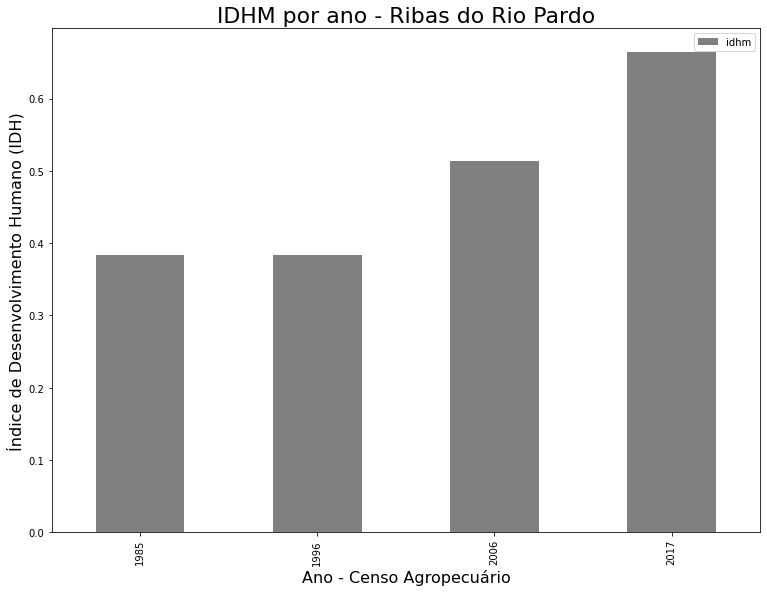

In [36]:
area_x_idh_bar_ribas = dados.loc[dados['municipio'] == 'Ribas do Rio Pardo', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_ribas.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Ribas do Rio Pardo', color='gray')

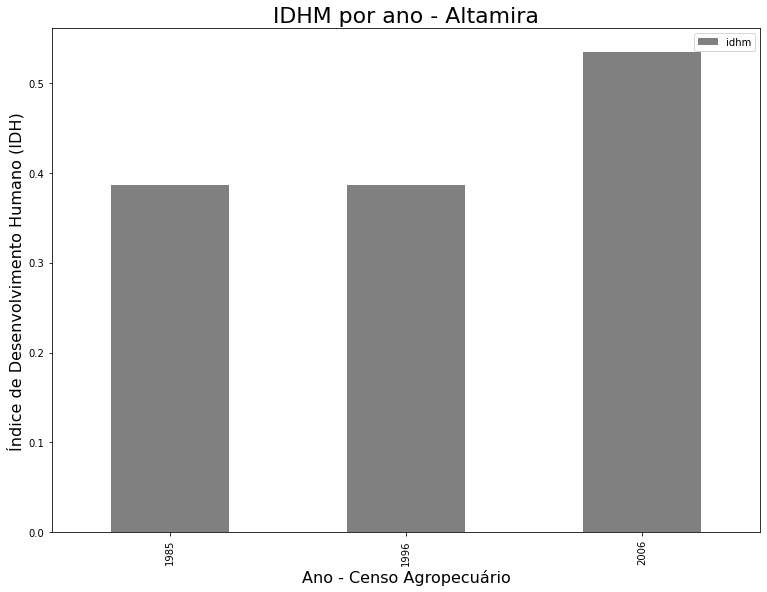

In [37]:
area_x_idh_bar_altamira = dados.loc[dados['municipio'] == 'Altamira', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_altamira.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Altamira', color='gray')

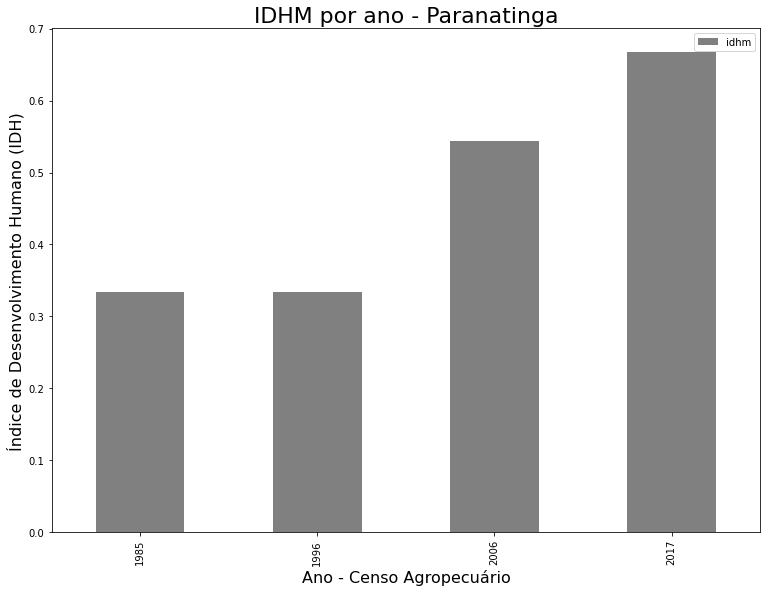

In [38]:
area_x_idh_bar_paranatinga = dados.loc[dados['municipio'] == 'Paranatinga', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_paranatinga.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Paranatinga', color='gray')

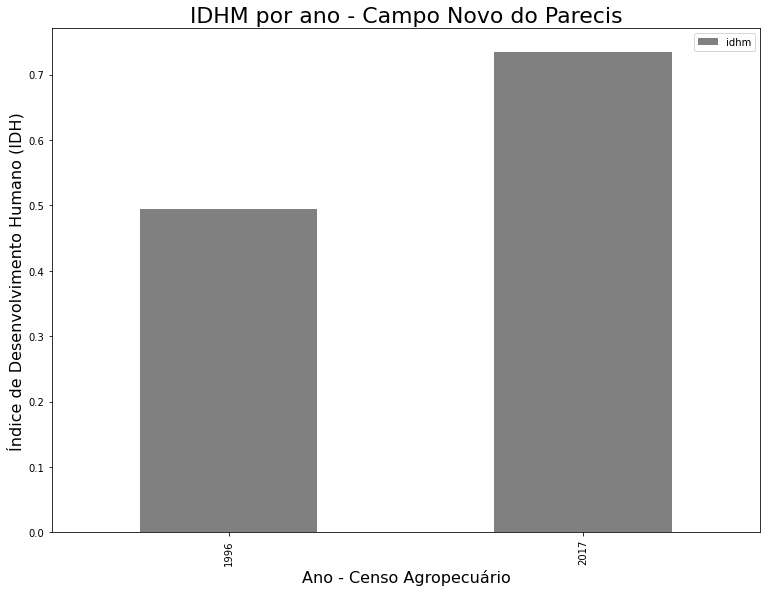

In [39]:
area_x_idh_bar_campo = dados.loc[dados['municipio'] == 'Campo Novo do Parecis', ['ano_censo_agropecuario', 'municipio','idhm']].groupby(['ano_censo_agropecuario']).sum()
area_x_idh_bar_campo.plot(kind='bar', ylabel='Índice de Desenvolvimento Humano (IDH)',xlabel='Ano - Censo Agropecuário', title= 'IDHM por ano - Campo Novo do Parecis', color='gray')

# Matriz de Correlação

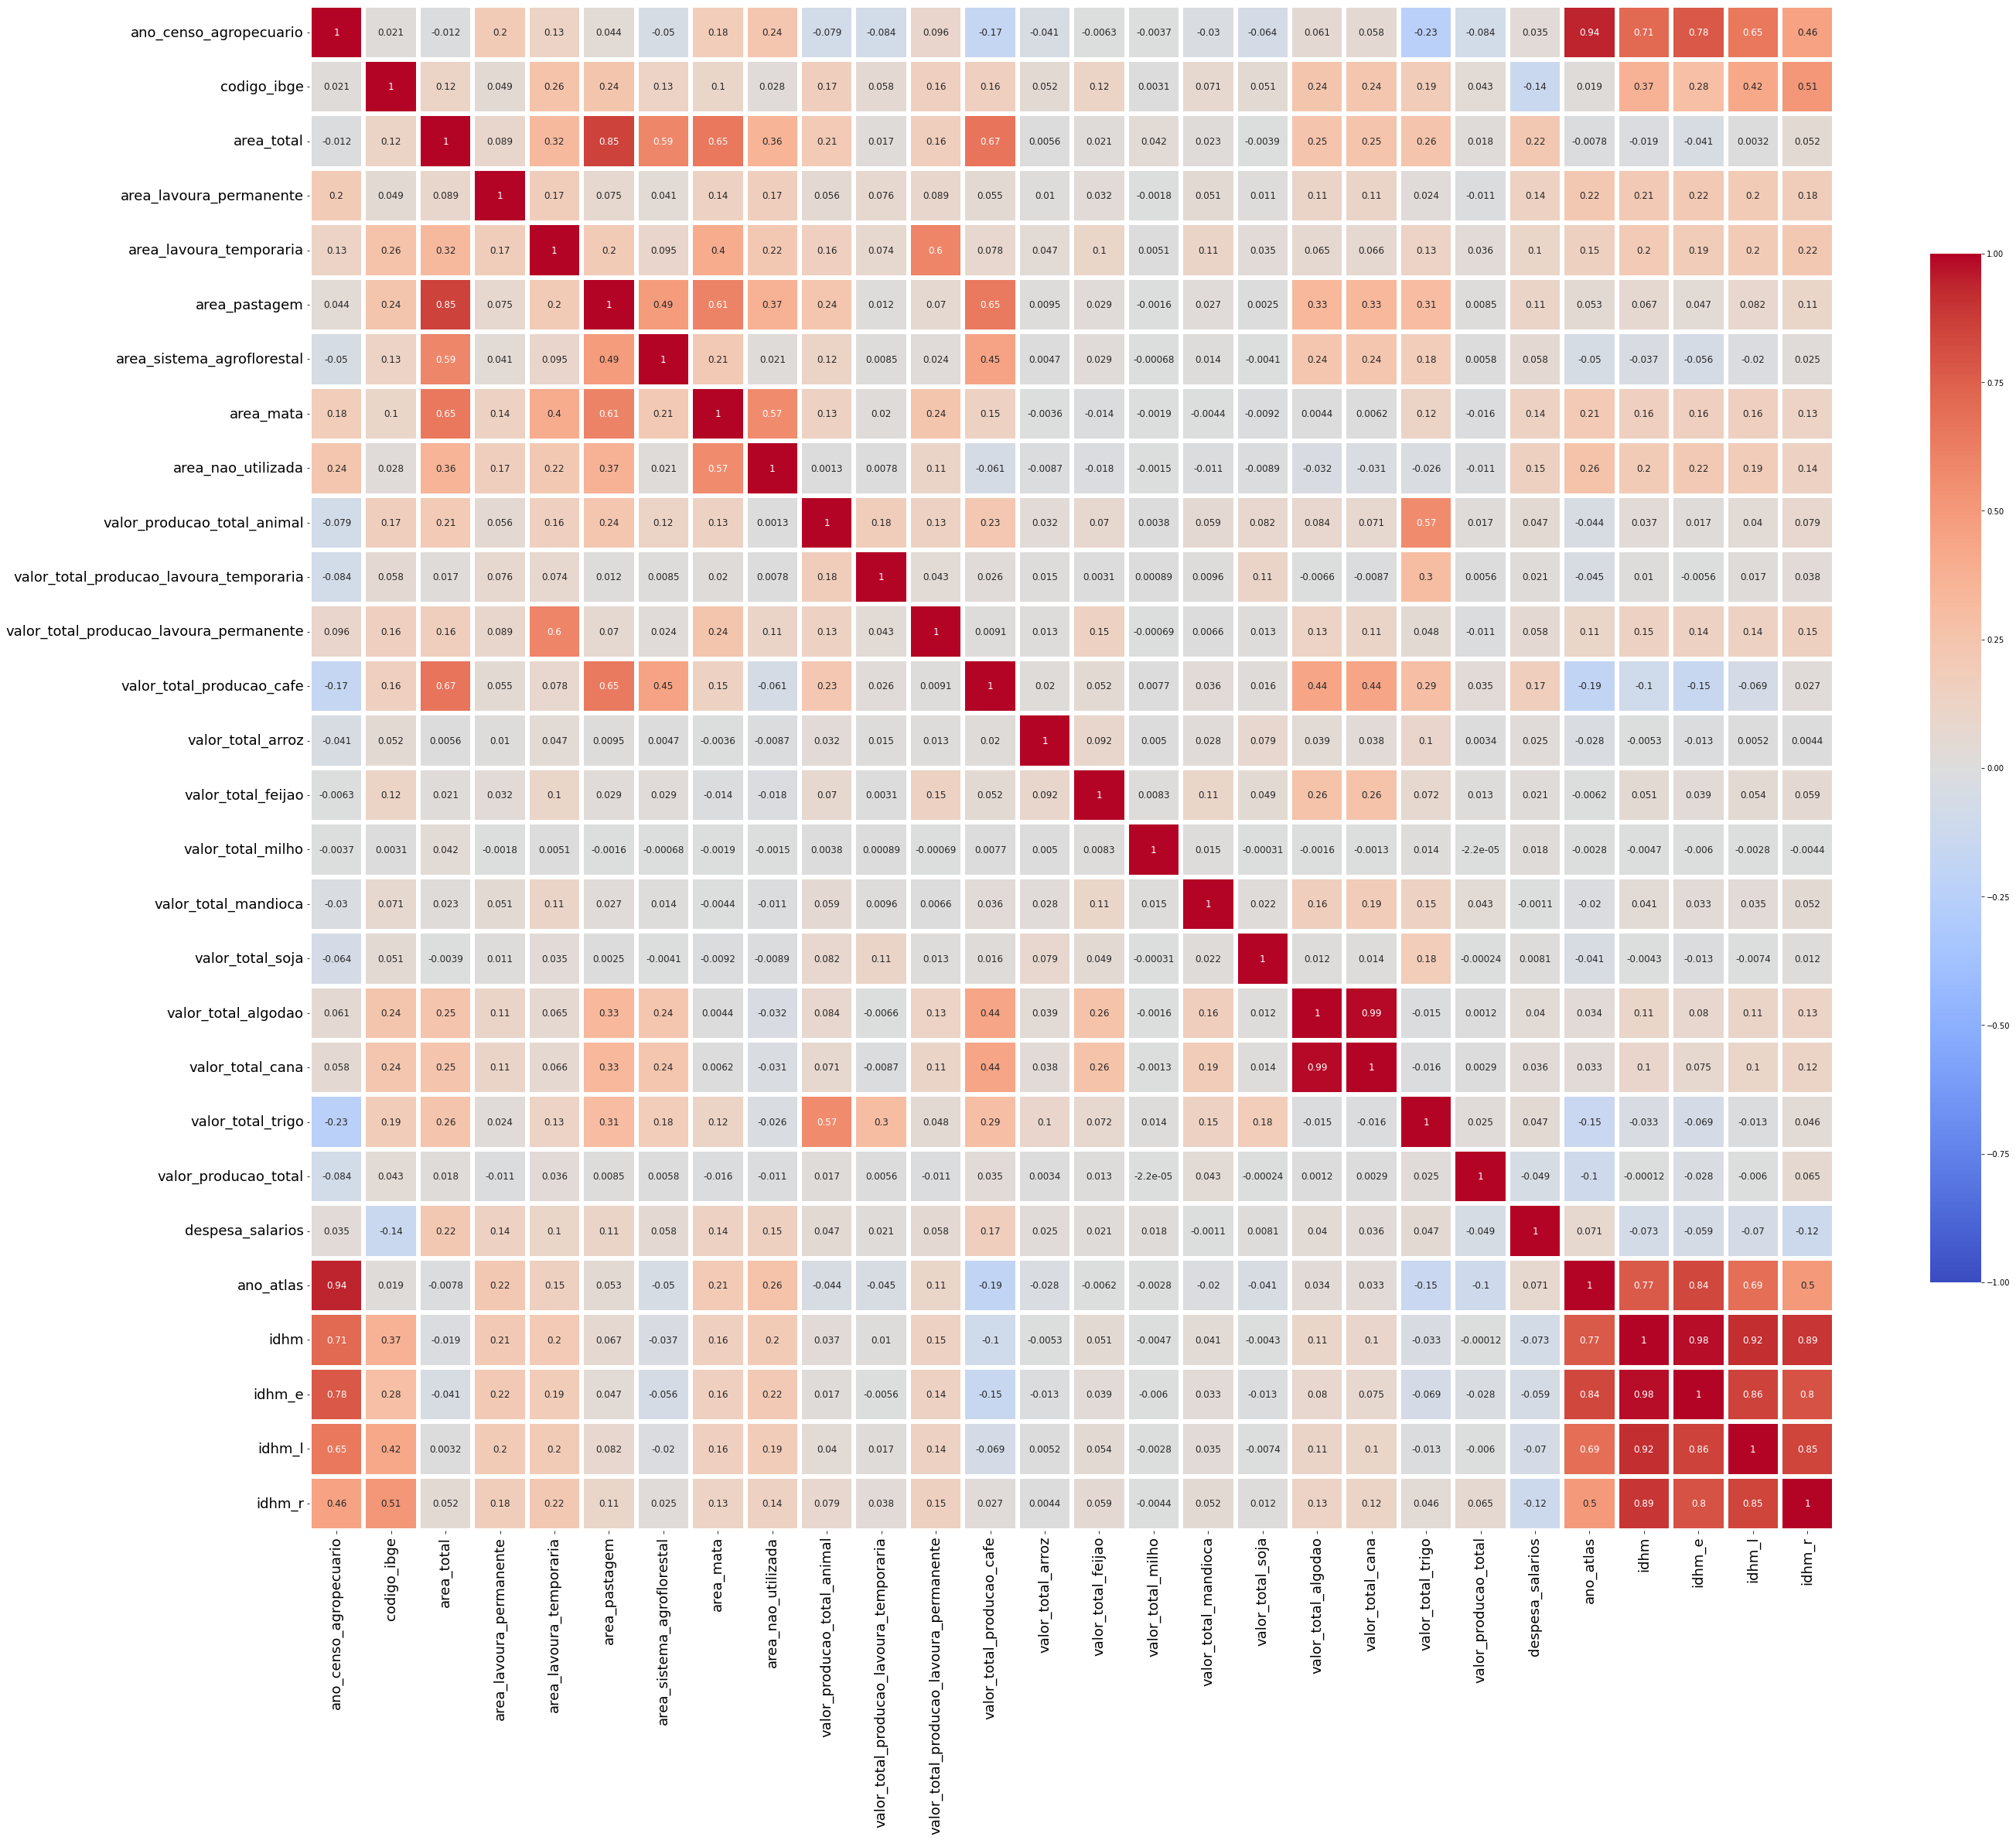

In [40]:
correlacao = dados.corr()
plt.figure(figsize=(40, 40))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
graph = sns.heatmap(correlacao, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, square=True,
                    linewidths=5, cbar_kws={'shrink': 0.5}, annot_kws={'size': 12})
graph.set_xticklabels(graph.get_xmajorticklabels(), fontsize=18)
graph.set_yticklabels(graph.get_ymajorticklabels(), fontsize=18)
plt.tight_layout()
plt.savefig('Correlation.jpeg')

# Criação dos Modelos de Machine Learning

Determinando variável alvo

In [41]:
y=dados['despesa_salarios']
x=dados.drop(columns=['uf','codigo_ibge','ano_censo_agropecuario','ano_atlas','idhm','idhm_e','idhm_l','idhm_r','municipio','despesa_salarios'])

Separação de base Treino e Teste

In [42]:
treino_x,val_x,treino_y,val_y=train_test_split(x,y,random_state=1,train_size=0.8)
treino_x.shape

(15766, 20)

In [43]:
x.head()

,area_total,area_lavoura_permanente,area_lavoura_temporaria,area_pastagem,area_sistema_agroflorestal,area_mata,area_nao_utilizada,valor_producao_total_animal,valor_total_producao_lavoura_temporaria,valor_total_producao_lavoura_permanente,valor_total_producao_cafe,valor_total_arroz,valor_total_feijao,valor_total_milho,valor_total_mandioca,valor_total_soja,valor_total_algodao,valor_total_cana,valor_total_trigo,valor_producao_total
0,347067.94000,0.00000,0.00000,0.00000,696660.25000,0.00000,64,0.00000,0.00000,14160.41000,71654,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,304.50000
1,347067.94000,0.00000,0.00000,0.00000,0.00000,0.00000,12,0.00000,0.00000,857.00000,150832,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,15.00000
2,359879.88000,0.00000,0.00000,0.00000,134616.75000,0.00000,111,0.00000,0.00000,0.00000,344500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,304.50000
3,334256.00000,5235.00000,5341.00000,221786.00000,1573.00000,89480.00000,10692,19.00000,18.00000,1282.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,594.00000
8,221698.76667,0.00000,0.00000,0.00000,0.00000,0.00000,3,0.00000,0.00000,5790.77000,14486,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1550.50000


# Kneighbors Regressor

O primeiro modelo a ser testado é o Kneighbors Regressor. O KNeighbors Regressor (KNN) é um algoritmo de aprendizado supervisionado de máquina que pode ser utilizado para problemas de regressão e de classificação, nos quais as variáveis são dados numéricos contínuos. O k é o número de vizinhos mais próximos das “features” que o algoritmo vai analisar para a predição dos dados. 

In [44]:
modelokr=KNeighborsRegressor(2)
modelokr.fit(treino_x,treino_y)
predicaokr=modelokr.predict(val_x)

# Validação (KNN)

In [45]:
mae_knn=mean_absolute_error(val_y,predicaokr)
print(mae_knn)

421.03954396769024


In [46]:
r2_modelo_knn=r2_score(val_y,predicaokr)
print(r2_modelo_knn)

0.052526645002960115


# Decision Tree

O modelo Decision Tree Regressor é um algoritmo de aprendizado de máquina supervisionado e pode ser utilizado para prever valores numéricos contínuos, apresenta uma estrutura de árvores com três tipos de nós. O nó inicial apresenta toda a amostra de dados que por meio de várias iterações é capaz de prever um valor adequado ao problema quando chega aos nós folhas.

In [47]:
modelotree=DecisionTreeRegressor(random_state=1,min_samples_leaf=35)
modelotree.fit(treino_x,treino_y)
predicaotree=modelotree.predict(val_x)

# Validação - Decision Tree Regressor

In [48]:
mae_tree=mean_absolute_error(val_y,predicaotree)
print(mae_tree)

353.2970000104009


In [49]:
r2_modelo_tree=r2_score(val_y,predicaotree)
print(r2_modelo_tree)

0.3519963476402298


# Random Forest

O Random Forest é similar aos algoritmos apresentados anteriormente, ele utiliza um conjunto aleatório dos dados de treino antes de gerar várias árvores de decisão e combina os resultados dessas para chegar no seu resultado final. Também é utilizado pra fazer predições a partir de dados com valores contínuos.

In [50]:
modelorf=RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=100)
modelorf.fit(treino_x,treino_y)
predicaorf=modelorf.predict(val_x)

# Validação - Random Forest

In [51]:
mae_rf=mean_absolute_error(val_y,predicaorf)
print(mae_rf)

320.7110342356482


In [52]:
r2_modelo_rf=r2_score(val_y,predicaorf)
print(r2_modelo_rf)

0.4719294259529262


# Resultados

Entre os três modelos testados na nossa base de dados, o modelo de aprendizado de máqui-na que apresentou o melhor desempenho foi o Random Forest, segundo as métricas de avaliação escolhidas. 

In [53]:
modelos=['KNeighbors Regressor','Decision Tree Regressor', 'Random Forest']
mae=[mae_knn, mae_tree, mae_rf,]
r2=[r2_modelo_knn, r2_modelo_tree, r2_modelo_rf]

lista=list(zip(modelos, mae, r2))

resultados=pd.DataFrame(lista, columns=['Modelo','MAE','R-Quadrado'])

print(resultados)

                    Modelo       MAE  R-Quadrado
0     KNeighbors Regressor 421.03954     0.05253
1  Decision Tree Regressor 353.29700     0.35200
2            Random Forest 320.71103     0.47193
